# <center>Modeling</center>

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%run "../scripts/image_loading.py"

# Load the processed data

We load the preprocessed data and normalize it to [0,1].

In [3]:
def rescale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_dataset(dataset, batch_size=32): 
    dataset = dataset.batch(batch_size)  
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  
    return dataset
    
#load the training dataset
train_dataset_proc = tf.data.TFRecordDataset('../data/processed/cropped_train_data.tfrecord')
train_dataset_proc = train_dataset_proc.map(parse_example)
#train_dataset_proc = train_dataset_proc.map(preprocess_labels)
train_dataset_proc = train_dataset_proc.map(rescale_image)
train_dataset_proc = preprocess_dataset(train_dataset_proc)

Let's visualize a sample of images from the preprocessed dataset.

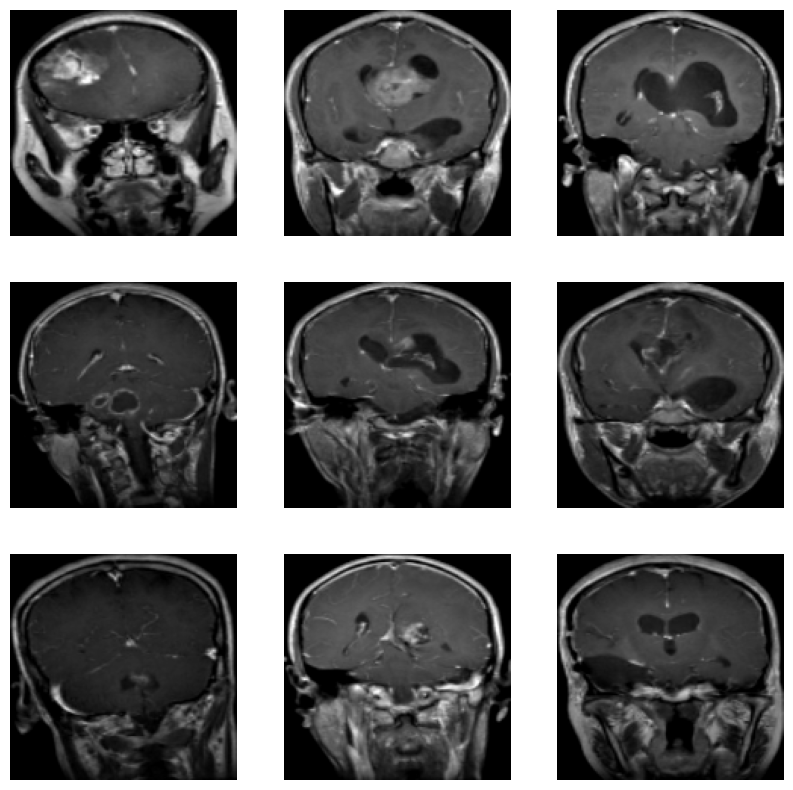

In [4]:
image_batch, label_batch = next(iter(train_dataset_proc))
plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):  
    plt.subplot(3, 3, i+1)  
    plt.imshow(image_batch[i].numpy())  
    plt.axis('off')
plt.show()

We load the test data

In [5]:
test_dataset_proc = tf.data.TFRecordDataset('../data/processed/cropped_test_data.tfrecord')
test_dataset_proc = test_dataset_proc.map(parse_example)
test_dataset_proc = test_dataset_proc.map(rescale_image)
test_dataset_proc = preprocess_dataset(test_dataset_proc)
#test_dataset_proc = test_dataset_proc.map(preprocess_labels)

## Modeling
Let's start with building the model.

In [6]:
def build_cnn_model(input_shape=(150, 150, 3), num_classes=4):
    
    model = models.Sequential()
    
    model.add(layers.InputLayer(shape=input_shape))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (7, 7), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
   
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


To train the model, we apply cross validation and split the dataset into 5 folds.

In [7]:
images = []
labels = []

for image, label in train_dataset_proc:
    #label = np.argmax(label, axis=1)
    for i in range(image.shape[0]):  
            images.append(image[i])  
            labels.append(label[i]) 

images = np.array(images)
labels = np.array(labels)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 


In [8]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []



for train_index, val_index in kf.split(images, labels):
    # Split the data into train and validation sets
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    
    model = build_cnn_model(input_shape=(150, 150, 3), num_classes=4)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    history = model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_val, y_val), verbose=1) 
    
    
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Compute the average accuracy and loss over all folds
average_accuracy = np.mean(val_accuracies)
average_loss = np.mean(val_losses)

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Loss: {average_loss:.4f}")

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2156s 15s/step - accuracy: 0.4002 - loss: 1.5050 - val_accuracy: 0.7183 - val_loss: 0.8132
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2101s 15s/step - accuracy: 0.7051 - loss: 0.8457 - val_accuracy: 0.8040 - val_loss: 0.5916
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2103s 15s/step - accuracy: 0.7888 - loss: 0.6353 - val_accuracy: 0.8346 - val_loss: 0.5308
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2085s 14s/step - accuracy: 0.8210 - loss: 0.5266 - val_accuracy: 0.8145 - val_loss: 0.5493
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2053s 14s/step - accuracy: 0.8308 - loss: 0.5120 - val_accuracy: 0.8513 - val_loss: 0.4489
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2046s 14s/step - accuracy: 0.8580 - loss: 0.4294 - val_accuracy: 0.8600 - val_loss: 0.4609
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2048s 14s/step - accuracy: 0.8771 - loss: 0.3797 - val_accuracy: 0.8959 - val_loss: 0.3468
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 2029s 14s/step - accuracy: 0.8884 - loss: 0

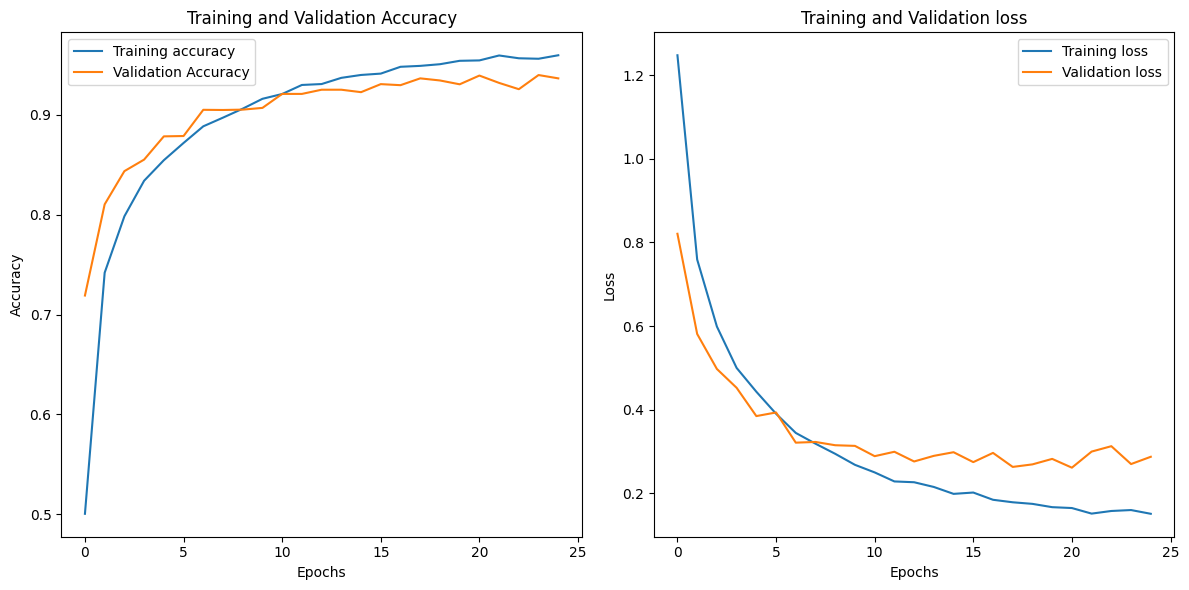

In [11]:

import matplotlib.pyplot as plt



mean_train_accuracies = np.mean(np.array(train_accuracies),axis=0)
mean_val_accuracies = np.mean(np.array(val_accuracies),axis=0)
mean_train_losses = np.mean(np.array(train_losses),axis=0)
mean_val_losses = np.mean(np.array(val_losses),axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, mean_train_accuracies,label='Training accuracy')
plt.plot(history.epoch, mean_val_accuracies,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.epoch, mean_train_losses,label='Training loss')
plt.plot(history.epoch, mean_val_losses,label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Next, we evaluate the model on the test dataset.

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset_proc,steps=1311//32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8741 - loss: 0.4508
Test Loss: 0.2509309947490692
Test Accuracy: 0.9320312738418579


## Hyperparameter tuning
We propose in the folowing to train and tune our model using Keras Tuner while also applying cross-validation.
### Stratified K-Fold Cross-Validation

In [23]:
images = []
labels = []

for image, label in train_dataset_proc:
    #label = np.argmax(label, axis=1)
    for i in range(image.shape[0]):  
            images.append(image[i])  
            labels.append(label[i]) 

images = np.array(images)
labels = np.array(labels)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Define the Hypermodel with Keras Tuner

In [24]:
def build_model(hp,num_classes=4):
    model = models.Sequential()

    
    model.add(layers.InputLayer(shape=(150, 150, 3)))
    
    
    model.add(layers.Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
    model.add(layers.Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), (5, 5), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
    model.add(layers.Conv2D(hp.Int('filters_3', min_value=128, max_value=512, step=128), (7, 7), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=0.1, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Next, we will split the data into training and validation sets within each fold and use Keras Tuner to tune the hyperparameters for each fold.

In [26]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='../models',
    project_name='Brain_Tumor_classification'
)

cv_results = []


for fold, (train_index, val_index) in enumerate(kf.split(images, labels), 1):
    print(f"Training fold {fold}...")

    
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    tuner.search(X_train,y_train, epochs=10, validation_data=(X_val,y_val))

    
    best_model = tuner.get_best_models(num_models=1)[0]

   
    val_loss, val_accuracy = best_model.evaluate(x=X_val,y=y_val)
    print(f"Validation accuracy for fold {fold}: {val_accuracy}")

    
    cv_results.append(val_accuracy)


mean_val_accuracy = np.mean(cv_results)
std_val_accuracy = np.std(cv_results)

print(f"Mean validation accuracy across folds: {mean_val_accuracy}")
print(f"Standard deviation of validation accuracy across folds: {std_val_accuracy}")


Trial 20 Complete [06h 26m 48s]
val_accuracy: 0.8643919229507446

Best val_accuracy So Far: 0.9107611775398254
Total elapsed time: 2d 21h 12m 12s


C:\Users\sabra\anaconda3\envs\cap3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9011 - loss: 0.4163
Validation accuracy for fold 1: 0.9107611775398254
Training fold 2...
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9673 - loss: 0.2446
Validation accuracy for fold 2: 0.9755030870437622
Training fold 3...
36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9661 - loss: 0.2446
Validation accuracy for fold 3: 0.9719789624214172
Training fold 4...
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9578 - loss: 0.2462
Validation accuracy for fold 4: 0.9640980958938599
Training fold 5...
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9642 - loss: 0.2433
Validation accuracy for fold 5: 0.971103310585022
Mean validation accuracy across folds: 0.9586889266967773
Standard deviation of validation accuracy across folds: 0.024247829658406134


In [27]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(best_trial.hyperparameters.values)

{'filters_1': 64, 'filters_2': 64, 'filters_3': 512, 'dense_units': 192, 'learning_rate': 0.0006759502243542753}


### Evaluate the best model

In [28]:

test_loss, test_accuracy = best_model.evaluate(test_dataset_proc,steps=1311//32)
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8858 - loss: 0.4326
Test Accuracy: 0.9156249761581421


In [32]:
predictions = best_model.predict(test_dataset_proc)
predicted_labels = np.argmax(predictions, axis=-1)  

41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step


In [34]:
test_labels = []
for image, label in test_dataset_proc:
    #label = np.argmax(label, axis=1)
    for i in range(image.shape[0]): 
        test_labels.append(label[i]) 

test_labels = np.array(test_labels)

precision = precision_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))
recall = recall_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))
f1 = f1_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))


roc_auc = roc_auc_score(test_labels, predictions, multi_class='ovr', average='macro')


cm = confusion_matrix(test_labels, predicted_labels)

Precision : 0.9153234403784606
Recall : 0.9131245461147421
F1-Score : 0.9134548014117674
AUC-ROC : 0.9855789551328838


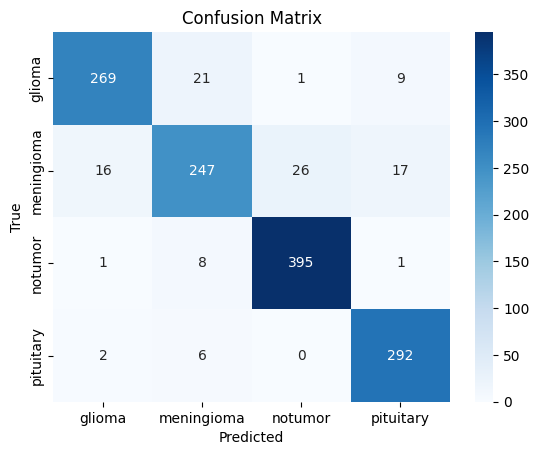

In [39]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-Score : {f1}")
print(f"AUC-ROC : {roc_auc}")


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Given that brain tumor classification typically involves detecting a serious medical condition, we need to ensure that the model is both accurate and reliable, particularly in detecting tumors and minimizing false negatives. The most important metric in this context is recall as false negatives (failing to identify a tumor) are much more dangerous than false positives (incorrectly identifying a tumor). The proposed model achieves a high accuracy rate and allows to minimize the false negative rate, it gives a 91% for recall.  Our model has an excellent ability to correctly classify positive and negative instances with an AUC of 0.98. this suggests that the model is very reliable and has a very low rate of false positives and false negatives.

In a future work, we can:

- Use data augmentation techniques to generate more data which can help the model generalize better and improve its ability to detect positive cases.
- Increase model complexity, either by adding more layers or more neurons in the dense layers which can help the model learn better feature representations.
- Tune more hyperparameters like batch size and dropout rate to explore different configurations and select the one that works best for improving recall.